# Rails and attachment experiment final execise

### general imports for the functions

In [268]:
from shapely.geometry import Polygon, LineString, Point
import matplotlib.pyplot as plt
import numpy as np


### body data for the function to process

In [269]:
import json

body_data = None
with open('roof_data3.json', 'r') as file:
    body_data = json.load(file)


## function and logics

the ridge angle is 1.506001660019575
new points [(730.4240244967277, 608.9101961897096), (730.052876032457, 608.9342783419714), (734.962906233884, 684.6065085051399), (735.3340546981548, 684.5824263528781)]
new points [(730.4240244967277, 608.9101961897096), (730.052876032457, 608.9342783419714), (734.962906233884, 684.6065085051399), (735.3340546981548, 684.5824263528781)]


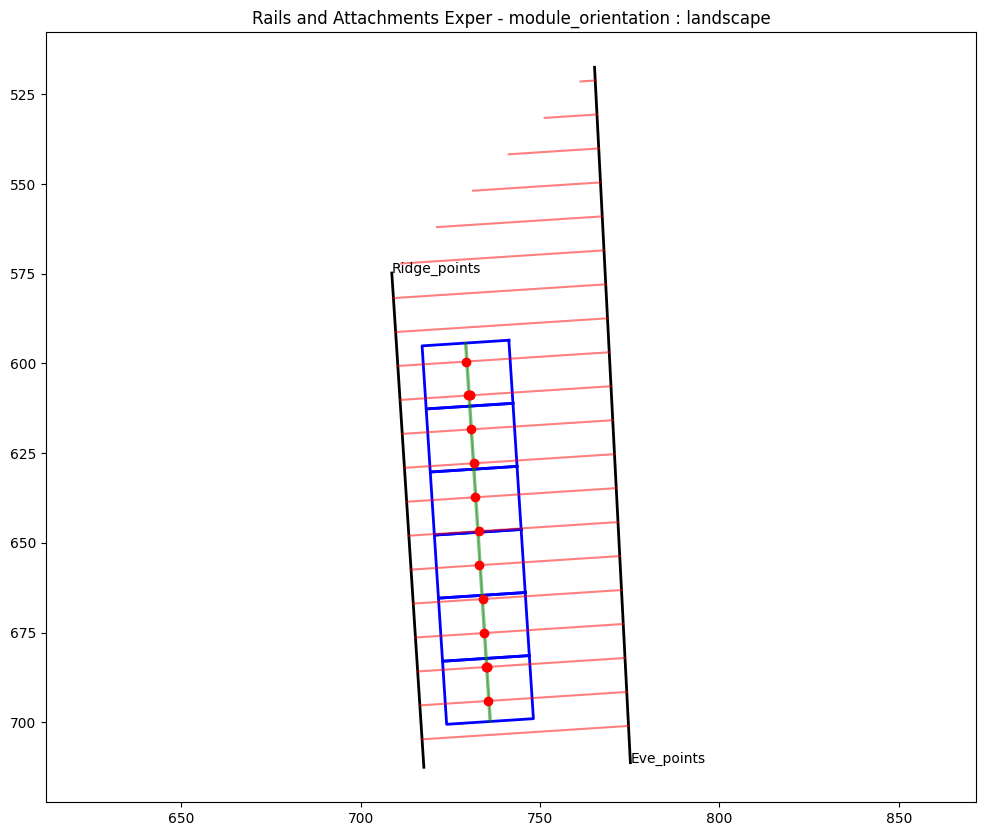

In [270]:





# COMMENT: api for rail and attachment logic
import contextlib
from dataclasses import dataclass, field
from enum import Enum
from math import cos
from operator import itemgetter
from typing import Dict, List, Optional, Tuple
from matplotlib import pyplot as plt
import numpy as np
from shapely.geometry import LineString, Polygon


class ModuleOrientation(Enum):
    LANDSCAPE = "landscape"
    PORTRAIT = "portrait"

    def __value__(self):
        return self.value


@dataclass()
class PlaceRailsAndAttachment:
    polygon_coords: list = field(default_factory=list)
    ridge_points: list = field(default_factory=list)
    eve_points: list = field(default_factory=list)
    rafter_lines: list = field(default_factory=list)
    module_orientation: str = ModuleOrientation.LANDSCAPE.value
    row_information: dict = field(default_factory=dict)
    row_count: int = field(default_factory=int)
    pitch_angle: int = 22

    # optional internal use attributes
    vertical_lines: List[LineString] = field(default_factory=list)
    horizontal_lines: List[LineString] = field(default_factory=list)
    new_ridge_lines: List[LineString] = field(default_factory=list)
    new_eve_lines: List[LineString] = field(default_factory=list)
    rail_lines: List[LineString] = field(default_factory=list)
    polygons: Optional[List[Polygon]] = None

    def __post_init__(self):
        self.pre_validate_fields()
        self.vertical_lines = self.line_string_maker(
            self.rafter_lines, set_rail_line=True
        )
        self.new_ridge_lines = self.line_string_maker(self.ridge_points)
        self.new_eve_lines = self.line_string_maker(self.eve_points)
        self.normalize_module_points()
        self.polygons = [Polygon(coords) for coords in self.polygon_coords]

    def pre_validate_fields(self):
        if not self.polygon_coords:
            raise ValueError("Polygon coordinates are required.")
        if not self.ridge_points:
            raise ValueError("Ridge points are required.")
        if not self.eve_points:
            raise ValueError("Eave points are required.")
        if not self.rafter_lines:
            raise ValueError("Rafter lines are required.")
        if not self.row_information:
            raise ValueError("Row information is required.")
        if not self.row_count or self.row_count <= 0:
            raise ValueError("Row count is required.")

    def normalize_module_points(self) -> None:
        """normalize the x and y points to a nested list model"""
        try:
            modules = [
                list(map(itemgetter("x", "y"), module_group))
                for module_group in self.polygon_coords
            ]
            setattr(self, "polygon_coords", modules)
        except ValueError:
            return ValueError("Invalid module points.")

    def get_offset_distance(self):
        return (
            22.6 * cos(self.pitch_angle)
            if self.module_orientation == ModuleOrientation.LANDSCAPE.value
            else (
                9.8 * cos(self.pitch_angle)
                if ModuleOrientation.PORTRAIT.value
                else ValueError
            )
        )

    def polygon_boundaries(self) -> Tuple:
        polygon_coords = self.polygon_coords
        min_x = min(min(x for x, y in poly) for poly in polygon_coords)
        max_x = max(max(x for x, y in poly) for poly in polygon_coords)
        min_y = min(min(y for x, y in poly) for poly in polygon_coords)
        max_y = max(max(y for x, y in poly) for poly in polygon_coords)
        return min_x, max_x, min_y, max_y

    def line_string_maker(
        self, line_segment: list, set_rail_line: bool = False
    ) -> list:
        lines = []
        for segment in line_segment:
            start, end = segment
            line = LineString([(start[0], start[1]), (end[0], end[1])])
            if set_rail_line:
                self.rail_lines.append(
                    [
                        {
                            "x1": start[0],
                            "y1": start[1],
                            "x2": end[0],
                            "y2": end[1],
                        },
                    ]
                )
            lines.append(line)
        return lines

    def ridge_angle(self):
        with contextlib.suppress(ValueError):
            ridge_coords = self.ridge_points[0]
            ridge_start, ridge_end = ridge_coords
            ridge_dx = ridge_end[0] - ridge_start[0]
            ridge_dy = ridge_end[1] - ridge_start[1]
            return np.arctan2(ridge_dy, ridge_dx)
        return None

    def rafter_coords(self):
        rafter_x_coords = [
            coord
            for line in self.rafter_lines
            for point in line
            for coord in [point[0]]
        ]
        min_rafter_x = min(rafter_x_coords)
        max_rafter_x = max(rafter_x_coords)
        return min_rafter_x, max_rafter_x

    
    def generate_horizontal_lines(self) -> None:
        ridge_angle = self.ridge_angle()
        print("the ridge angle is", ridge_angle)
        
        for polygon in self.polygons:
            x_coords, y_coords = polygon.exterior.xy
            poly_min_x = min(x_coords)
            poly_max_x = max(x_coords)
            poly_min_y = min(y_coords)
            poly_max_y = max(y_coords)

            height_range = poly_max_y - poly_min_y
            y1 = poly_min_y + 0.30 * height_range 
            y2 = poly_min_y +  0.60 * height_range

            

            extend_factor = 1.5
            extend_length = (poly_max_x - poly_min_x) * extend_factor
            
            for y_pos in [y1, y2]:
                
                center_x = (poly_min_x + poly_max_x) / 2
                
                offset_x = extend_length / 2
                
                if ridge_angle is not None:
                    offset_y = offset_x * np.tan(ridge_angle)
                else:
                    offset_y = 0
                    
                x_start = center_x - offset_x
                x_end = center_x + offset_x
                
                y_start = y_pos - offset_y
                y_end = y_pos + offset_y
                
                extended_line = LineString([(x_start, y_start), (x_end, y_end)])
                
                clipped_line = extended_line.intersection(polygon)
                
                if not clipped_line.is_empty and isinstance(clipped_line, LineString):
                    self.horizontal_lines.append(clipped_line)

    def first_and_last_polygon_attachmenting(self, polygon_intersections: dict) -> list:
        first_and_last_points: list = []
        def normalize_points(row_coords):
            return [[module["x"], module["y"]] for module in row_coords]

        for row_idx in range(self.row_count):
            row_key = f"row_{row_idx + 1}"
            row_data = self.row_information.get(row_key)
            if not row_data:
                continue
            
            first_row_coords = row_data.get("first_row")
            last_row_coords = row_data.get("last_row")

            first_row_polygon = (
                Polygon(normalize_points(first_row_coords))
                if first_row_coords
                else None
            )
            last_row_polygon = (
                Polygon(normalize_points(last_row_coords)) 
                if last_row_coords 
                else None
            )
            
            first_poly_idx = None
            last_poly_idx = None
            

            # REFACTOR : the below for loop requires changes with the each row attachment count 
            # CHECK : check the first or second point is already in the h_v intersection points and skip that point , inorder to avoid that -1 
            for poly_idx, poly in enumerate(self.polygons):
                if first_row_polygon and poly == first_row_polygon:
                    first_poly_idx = poly_idx
                    finding_keys_based_on_value = [
                        key for key, value in self.row_information.items()
                        if "modules" in value and any(
                            Polygon(normalize_points(module)) == first_row_polygon 
                            for module in value.get("modules", [])
                        )
                    ]
                    if finding_keys_based_on_value:
                        row_finds = finding_keys_based_on_value[0]
                        if row_finds not in self.each_row_attachment_count:
                            self.each_row_attachment_count[row_finds] = 0
                        self.each_row_attachment_count[row_finds] += 1
                        
                if last_row_polygon and poly == last_row_polygon:
                    last_poly_idx = poly_idx
                    finding_keys_based_on_value = [
                        key for key, value in self.row_information.items()
                        if "modules" in value and any(
                            Polygon(normalize_points(module)) == last_row_polygon 
                            for module in value.get("modules", [])
                        )
                    ]
                    if finding_keys_based_on_value:
                        row_finds = finding_keys_based_on_value[0]
                        if row_finds not in self.each_row_attachment_count:
                            self.each_row_attachment_count[row_finds] = 0
                        self.each_row_attachment_count[row_finds] += 1

            # for the first polygons
            if first_poly_idx is not None and first_poly_idx in polygon_intersections:
                sorted_first_points = sorted(
                    polygon_intersections[first_poly_idx], key=lambda point: point[0]
                )
                if len(sorted_first_points) >= 2:  
                    first_point = sorted_first_points[-1]
                    second_point = sorted_first_points[-2]
                    first_and_last_points.append(first_point)
                    first_and_last_points.append(second_point)
                else:
                    if sorted_first_points:  
                        first_and_last_points.append(sorted_first_points[-1])

            # for the last polygons
            if last_poly_idx is not None and last_poly_idx in polygon_intersections:
                sorted_last_points = sorted(
                    polygon_intersections[last_poly_idx], key=lambda point: point[0]
                )
                if len(sorted_last_points) >= 2:  
                    last_point = sorted_last_points[0]
                    first_and_last_points.append(last_point)
                    first_and_last_points.append(sorted_last_points[1])
                else:
                    if sorted_last_points:
                        first_and_last_points.append(sorted_last_points[0])

        return first_and_last_points

    def h_v_intersections(self) -> list:
        h_v_intersections_points: list = []

        polygon_intersections = {poly_idx: [] for poly_idx in range(len(self.polygons))}

        self.each_row_attachment_count = {}
        for poly_idx, polygon in enumerate(self.polygons):
            for h_idx, h_line in enumerate(self.horizontal_lines):
                for v_idx, v_line in enumerate(self.vertical_lines):
                    h_v_point = h_line.intersection(v_line)
                    if not h_v_point.is_empty and polygon.contains(h_v_point):
                        polygon_intersections[poly_idx].append(
                            (h_v_point.x, h_v_point.y)
                            )
                        if (h_idx % 2 == 0 and v_idx % 2 == 0) or (h_idx % 2 == 1 and v_idx % 2 == 1):
                            h_v_intersections_points.append((h_v_point.x, h_v_point.y))
                            
                            finding_keys_based_on_value = [
                                key for key, value in row_information.items()
                                if "modules" in value and any(
                                    Polygon([(point["x"], point["y"]) for point in module]) == polygon 
                                    for module in value["modules"]
                                )
                            ]
                            if finding_keys_based_on_value: 
                                row_finds = finding_keys_based_on_value[0]
                                if row_finds not in self.each_row_attachment_count:
                                    self.each_row_attachment_count[row_finds] = 0
                                self.each_row_attachment_count[row_finds] += 1

                        
        first_and_last_point_extends = self.first_and_last_polygon_attachmenting(
            polygon_intersections
        )
        print("new points"  , first_and_last_point_extends)
        return h_v_intersections_points + first_and_last_point_extends

    def convert_to_points(self, lines) -> List[Dict[str, float]]:
        points = []
        for line in lines:
            x_coords, y_coords = line.xy
            points.append({"x": x_coords[0], "y": y_coords[0]})
            points.append({"x": x_coords[1], "y": y_coords[1]})
        return points


    def plot(self):
        plt.figure(figsize=(12,10))

        h_v_intersection_points  =  self.h_v_intersections()

        
        # Plot polygons
        for polygon in self.polygons:
            x, y = polygon.exterior.xy
            plt.plot(x, y, 'b-', linewidth=2)

        # Plot ridge lines
        for line in self.new_ridge_lines:  
            x, y = line.xy
            plt.plot(x, y, 'k-', linewidth=2)
            plt.text(x[0], y[0], 'Ridge_points', fontsize=10)

        # Plot eve lines
        for line in self.new_eve_lines: 
            x, y = line.xy
            plt.plot(x, y, 'k-', linewidth=2)
            plt.text(x[0], y[0], 'Eve_points', fontsize=10)

        # Plot horizontal lines (rail lines)
        for line in self.horizontal_lines:
            x, y = line.xy
            plt.plot(x, y, 'g-', alpha=0.5)

        # Plot vertical lines (rafter lines)
        for line in self.vertical_lines:
            x, y = line.xy
            self.rail_lines.append({
                "x" : x.tolist()[0] ,
                "y" : y.tolist()[0]
            })
            plt.plot(x, y, 'r-', alpha=0.5)

        # plot h-v lines
        for point in h_v_intersection_points:
            plt.plot(point[0], point[1], 'ro', markersize=6)

        # # Set plot limits
        # COMMENT: add plot limits to the fig size (not recommended for the getting points for canvas draw)
        x_values = [coord[0] for poly in self.polygon_coords for coord in poly] + \
                  [seg[0][0] for seg in self.rafter_lines] + [seg[1][0] for seg in self.rafter_lines]
        y_values = [coord[1] for poly in self.polygon_coords for coord in poly] + \
                  [seg[0][1] for seg in self.rafter_lines] + [seg[1][1] for seg in self.rafter_lines]

        plt.xlim(min(x_values) - 50, max(x_values) + 50)
        plt.ylim(min(y_values) - 50, max(y_values) + 50)

        plt.title(f"Rails and Attachments Exper - module_orientation : {module_orientation}")
        plt.grid(False)
        plt.axis('equal')
        plt.gca().invert_yaxis()
        plt.show()
    

    def normalize_horizondal_points(self):
        return [
                [
                    {
                        "x1": item.coords[0][0],
                        "y1": item.coords[0][1],
                        "x2": item.coords[1][0],
                        "y2": item.coords[1][1],
                    }
                ]
                for item in self.horizontal_lines
            ] if self.horizontal_lines else None

    def main(self) -> Dict:
        self.polygon_boundaries()
        self.rafter_coords()
        self.generate_horizontal_lines()
        intersection_points = self.h_v_intersections()
        self.plot()
        return {
            "rail_lines": self.normalize_horizondal_points(),
            "row_count"  : { key : value - 1 for key , value in self.each_row_attachment_count.items()},
            "attachment_points": [
                {"x": item[0], "y": item[1]} for item in intersection_points
            ],
        }




data = body_data


polygon_coords = data.get("polygon_coords", [])
ridge_points = data.get("ridge_points", [])
eve_points = data.get("eve_points", [])
rafter_lines = data.get("rafter_lines", [])
module_orientation = data.get("module_orientation", "landscape")
row_information = data.get("row_information", {})
row_count = data.get("row_count", 0)
MODULE_WIDTH = data.get("module_width", 0)
MODULE_HEIGHT = data.get("module_height", 0)
rails_attachment_data = PlaceRailsAndAttachment(
    polygon_coords,
    ridge_points,
    eve_points,
    rafter_lines,
    module_orientation,
    row_information,
    row_count
).main()

